## 1. Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow

from keras import optimizers
from keras.applications import xception
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from numpy.random import seed

%matplotlib inline

# Set seed
seed(1)
tensorflow.random.set_seed(2)

## 2. Mount Drive and Read Data

In [2]:
# Mount google drive
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/BT4221 Project/Processing   Model /Data')

In [4]:
!pwd

/content/drive/.shortcut-targets-by-id/1tBdSji21KgPglmR793LZtaDQOEIckCP4/BT4221 Project/Processing   Model /Data


In [5]:
train_dir = '/content/drive/My Drive/Data/train'
test_dir = '/content/drive/My Drive/Data/test'

In [6]:
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
num_covid19 = len(os.listdir(os.path.join(train_dir, 'COVID19')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")
print(f"COVID19={num_covid19}")


print("Test set:\n========================================")
num_pneumonia_test = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
num_normal_test = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
num_covid19_test = len(os.listdir(os.path.join(test_dir, 'COVID19')))
print(f"PNEUMONIA={num_pneumonia_test}")
print(f"NORMAL={num_normal_test}")
print(f"COVID19={num_covid19_test}")

Train set:
PNEUMONIA=3418
NORMAL=1266
COVID19=1349
Test set:
PNEUMONIA=855
NORMAL=317
COVID19=116


## 3. Running of Model

### Image Pre-Processing

In [7]:
img_size = 299

In [8]:
# Image Preprocessing to perform standardization
train_image_datagen = ImageDataGenerator(rescale=1./299)

train_datagen = train_image_datagen.flow_from_directory(train_dir, 
                                                        batch_size=32, 
                                                        shuffle=True, 
                                                        class_mode='categorical', 
                                                        target_size=(img_size, img_size))

test_image_datagen = ImageDataGenerator(rescale=1./299)

test_datagen = test_image_datagen.flow_from_directory(test_dir, 
                                                      batch_size=16, 
                                                      shuffle=True, 
                                                      class_mode='categorical', 
                                                      target_size=(img_size, img_size))

Found 6033 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [9]:
# Compute class weights
print(train_datagen.class_indices)

weight_for_covid19 = num_covid19 / (num_normal + num_pneumonia + num_covid19)
weight_for_normal = num_normal / (num_normal + num_pneumonia + num_covid19)
weight_for_pneumonia = num_pneumonia / (num_normal + num_pneumonia + num_covid19)

class_weight = {0: weight_for_covid19, 1: weight_for_normal, 2: weight_for_pneumonia}

print(f"Weight for class 0 (Covid19): {weight_for_covid19:.2f}")
print(f"Weight for class 1 (Normal): {weight_for_normal:.2f}")
print(f"Weight for class 2 (Pneumonia): {weight_for_pneumonia:.2f}")

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Weight for class 0 (Covid19): 0.22
Weight for class 1 (Normal): 0.21
Weight for class 2 (Pneumonia): 0.57


### Base Model - Xception

In [10]:
base_model = xception.Xception(weights='imagenet', 
                               include_top=False, 
                               input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False
    
# base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step


### 3.1 Model 1: xception_main
- Training Accuracy: 100%
- Testing Accuracy: 96.04%

#### Model

In [ ]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(512, activation="relu")(x)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("xception_main.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 30,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/30
189/189 [==============================] - 1632s 8s/step - loss: 0.4125 - accuracy: 0.8961 - val_loss: 0.3877 - val_accuracy: 0.9379

Epoch 00001: val_accuracy improved from -inf to 0.93789, saving model to xception_main.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
189/189 [==============================] - 242s 1s/step - loss: 0.0645 - accuracy: 0.9584 - val_loss: 0.3878 - val_accuracy: 0.9270

Epoch 00002: val_accuracy did not improve from 0.93789
Epoch 3/30
189/189 [==============================] - 235s 1s/step - loss: 0.0506 - accuracy: 0.9612 - val_loss: 0.2197 - val_accuracy: 0.9573

Epoch 00003: val_accuracy improved from 0.93789 to 0.95730, saving model to xception_main.h5
Epoch 4/30
189/189 [==============================] - 229s 1s/step - loss: 0.0299 - accuracy: 0.9733 - val_loss: 0.1980 - val_accuracy: 0.9581

Epoch 00004: val_accuracy improved from 0.95730 to 0.95807, saving model to xception_main.h5
Epoch 5/30
189/189 [==============================] - 235s 1s/step - loss: 0.0240 - accuracy: 0.9761 - val_loss: 0.1705 - val_accuracy: 0.9612

Epoch 00005: val_accuracy improved from 0.95807 to 0.96118, saving model to xception_main.h5
Epoch 6/30
189/189 [==============================] - 239s 1s/step - loss: 0.0152 - accura

#### Model Evaluation

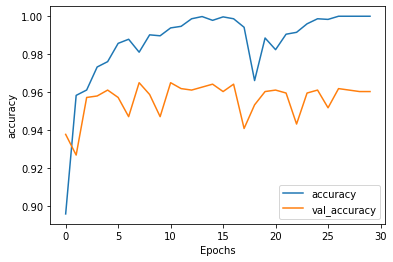

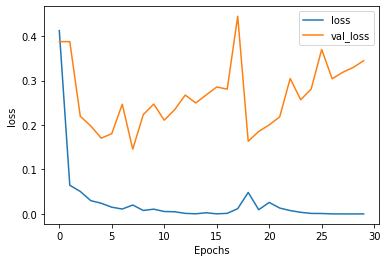

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

81/81 [==============================] - 42s 516ms/step - loss: 0.3449 - accuracy: 0.9604
Test Accuracy: 96.04%
189/189 [==============================] - 188s 991ms/step - loss: 1.4296e-05 - accuracy: 1.0000
Train Accuracy: 100.00%


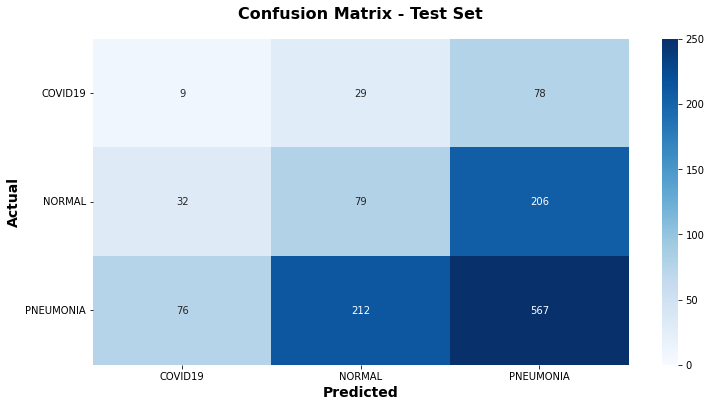

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

### 3.2 Model 2: xception_main1
- Training Accuracy: 
- Testing Accuracy: 

#### Model

In [11]:
# Adding custom layers 
x = base_model.output
x = Flatten()(x)

x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)

output = Dense(3, activation="softmax")(x) # 3 classes
model = Model(inputs = base_model.input, outputs = output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint("xception_main1.h5", monitor='val_accuracy', mode='auto', verbose=1, save_best_only=True)

# Running of Model
history = model.fit(train_datagen,
                    validation_data = test_datagen, 
                    class_weight = class_weight,
                    epochs = 30,
                    callbacks = [checkpoint],
                    verbose = 1
          )

Epoch 1/30
189/189 [==============================] - 4316s 23s/step - loss: 0.5404 - accuracy: 0.9025 - val_loss: 0.4849 - val_accuracy: 0.9371

Epoch 00001: val_accuracy improved from -inf to 0.93711, saving model to xception_main1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
189/189 [==============================] - 234s 1s/step - loss: 0.0557 - accuracy: 0.9665 - val_loss: 0.3358 - val_accuracy: 0.9402

Epoch 00002: val_accuracy improved from 0.93711 to 0.94022, saving model to xception_main1.h5
Epoch 3/30
189/189 [==============================] - 232s 1s/step - loss: 0.0411 - accuracy: 0.9733 - val_loss: 0.3947 - val_accuracy: 0.9387

Epoch 00003: val_accuracy did not improve from 0.94022
Epoch 4/30
189/189 [==============================] - 231s 1s/step - loss: 0.0370 - accuracy: 0.9751 - val_loss: 0.3375 - val_accuracy: 0.9495

Epoch 00004: val_accuracy improved from 0.94022 to 0.94953, saving model to xception_main1.h5
Epoch 5/30
189/189 [==============================] - 232s 1s/step - loss: 0.0288 - accuracy: 0.9783 - val_loss: 0.2431 - val_accuracy: 0.9620

Epoch 00005: val_accuracy improved from 0.94953 to 0.96196, saving model to xception_main1.h5
Epoch 6/30
189/189 [==============================] - 231s 1s/step - loss: 0.0084 - acc

#### Model Evaluation

In [ ]:
# Print Graphs (training vs testing)
def plotting(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.ylabel(string)
    plt.xlabel("Epochs")
    plt.legend([string, "val_"+string])
    plt.show()

plotting(history, "accuracy")
plotting(history, "loss")

In [ ]:
# Get Accuracy Rate of Model (training and testing)
scores = model.evaluate(test_datagen)
print(f"Test Accuracy: {scores[1] * 100:.2f}%")

scores = model.evaluate(train_datagen)
print(f"Train Accuracy: {scores[1] * 100:.2f}%")

In [ ]:
# Print Confusion Matrix
classes = ['COVID19', 'NORMAL', 'PNEUMONIA']

pred_class = model.predict(test_datagen)
predictions = np.array(list(map(lambda x: np.argmax(x), pred_class)))

y_true= test_datagen.classes

CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index=classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);